In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [23]:
dirs = [
        "db5_saliency_warmstart_seed=1",
        "db5_saliency_warmstart_seed=2"
        ]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [24]:
dics = []
for i in range(len(dirs)):
    # define indexes
    res = results[i]
    mos = models[i]
    lamL1wave = np.array(res['lamL1wave'])
    lamL1attr = np.array(res['lamL1attr'])
    lamL1wave_grid = np.unique(lamL1wave)
    lamL1attr_grid = np.unique(lamL1attr)
    R = len(lamL1wave_grid)
    C = len(lamL1attr_grid)

    # collect results
    dic = {'psi':{},
           'wt': {},
           'x': {},
           'lamL1wave': {},
           'lamL1attr': {},
           'index': {}}

    for r in range(R):
        for c in range(C):
            loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
            if loc.sum() == 1: 
                loc = np.argwhere(loc).flatten()[0]
                dic['index'][(r,c)] = loc
                wt = mos[loc]
                _, psi, x = get_wavefun(wt)

                dic['wt'][(r,c)] = wt
                dic['psi'][(r,c)] = psi  
                dic['x'][(r,c)] = x
                dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
                dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]
    dics.append(dic)

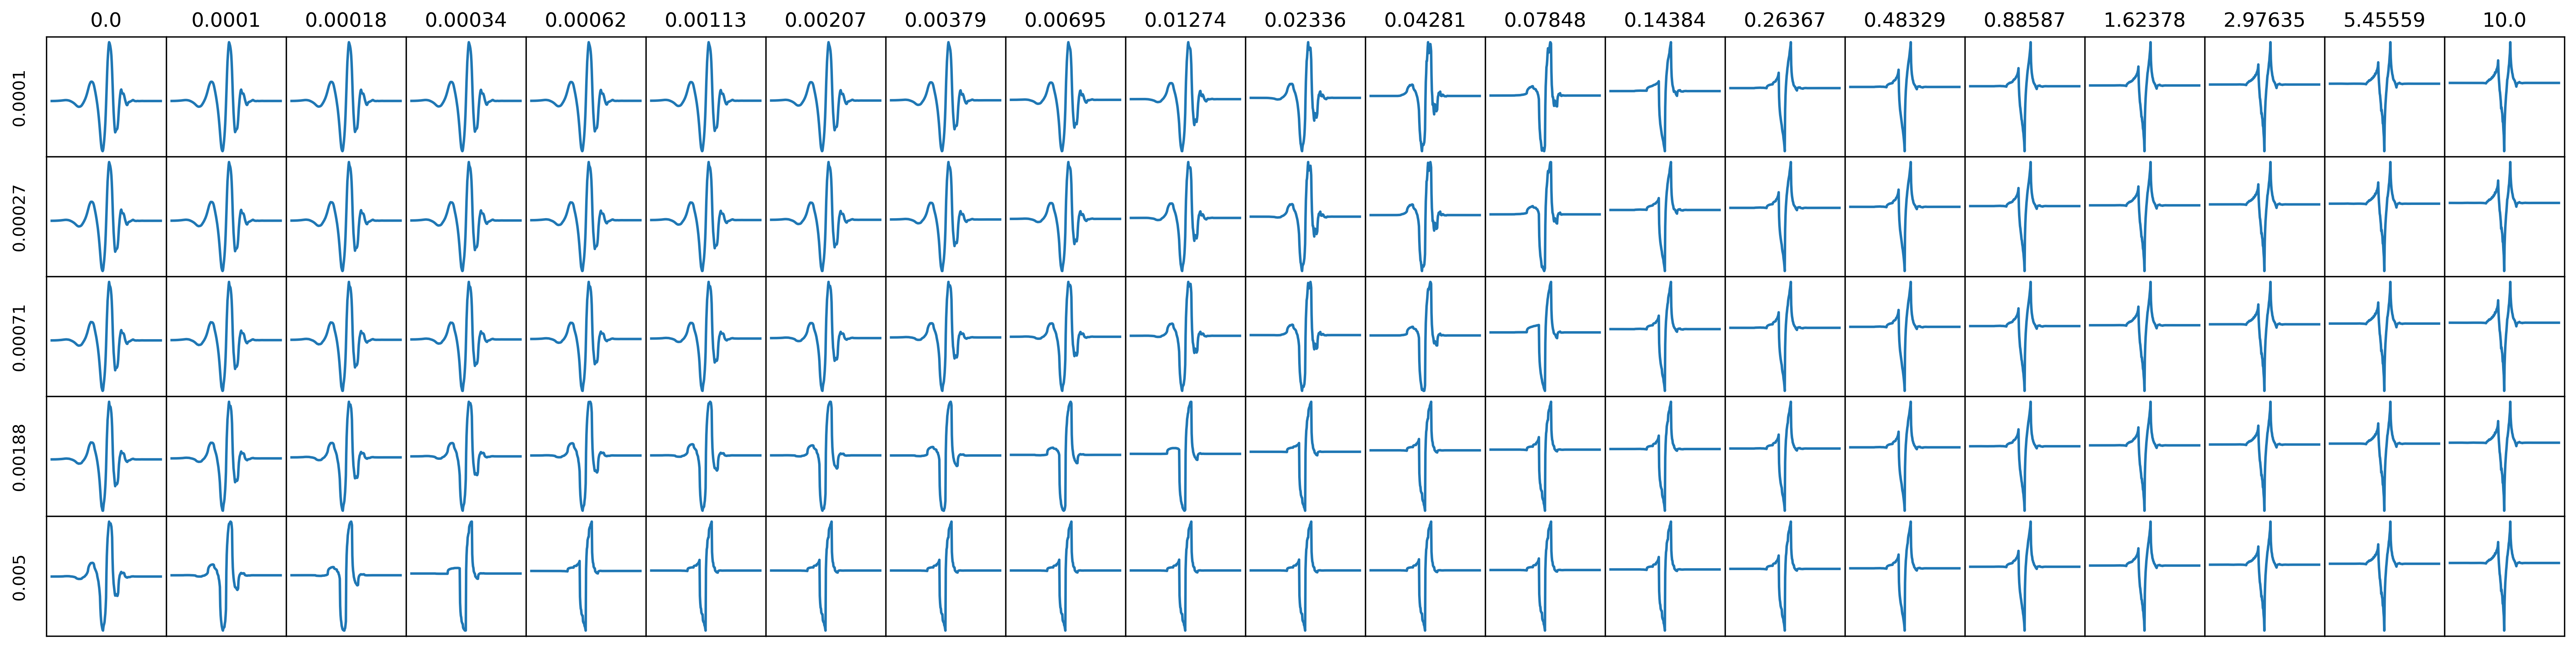

In [25]:
plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

index = 0 # select which result to display
lamwaves = np.fromiter(dics[index]['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dics[index]['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, dics[index]['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))
plt.show() 


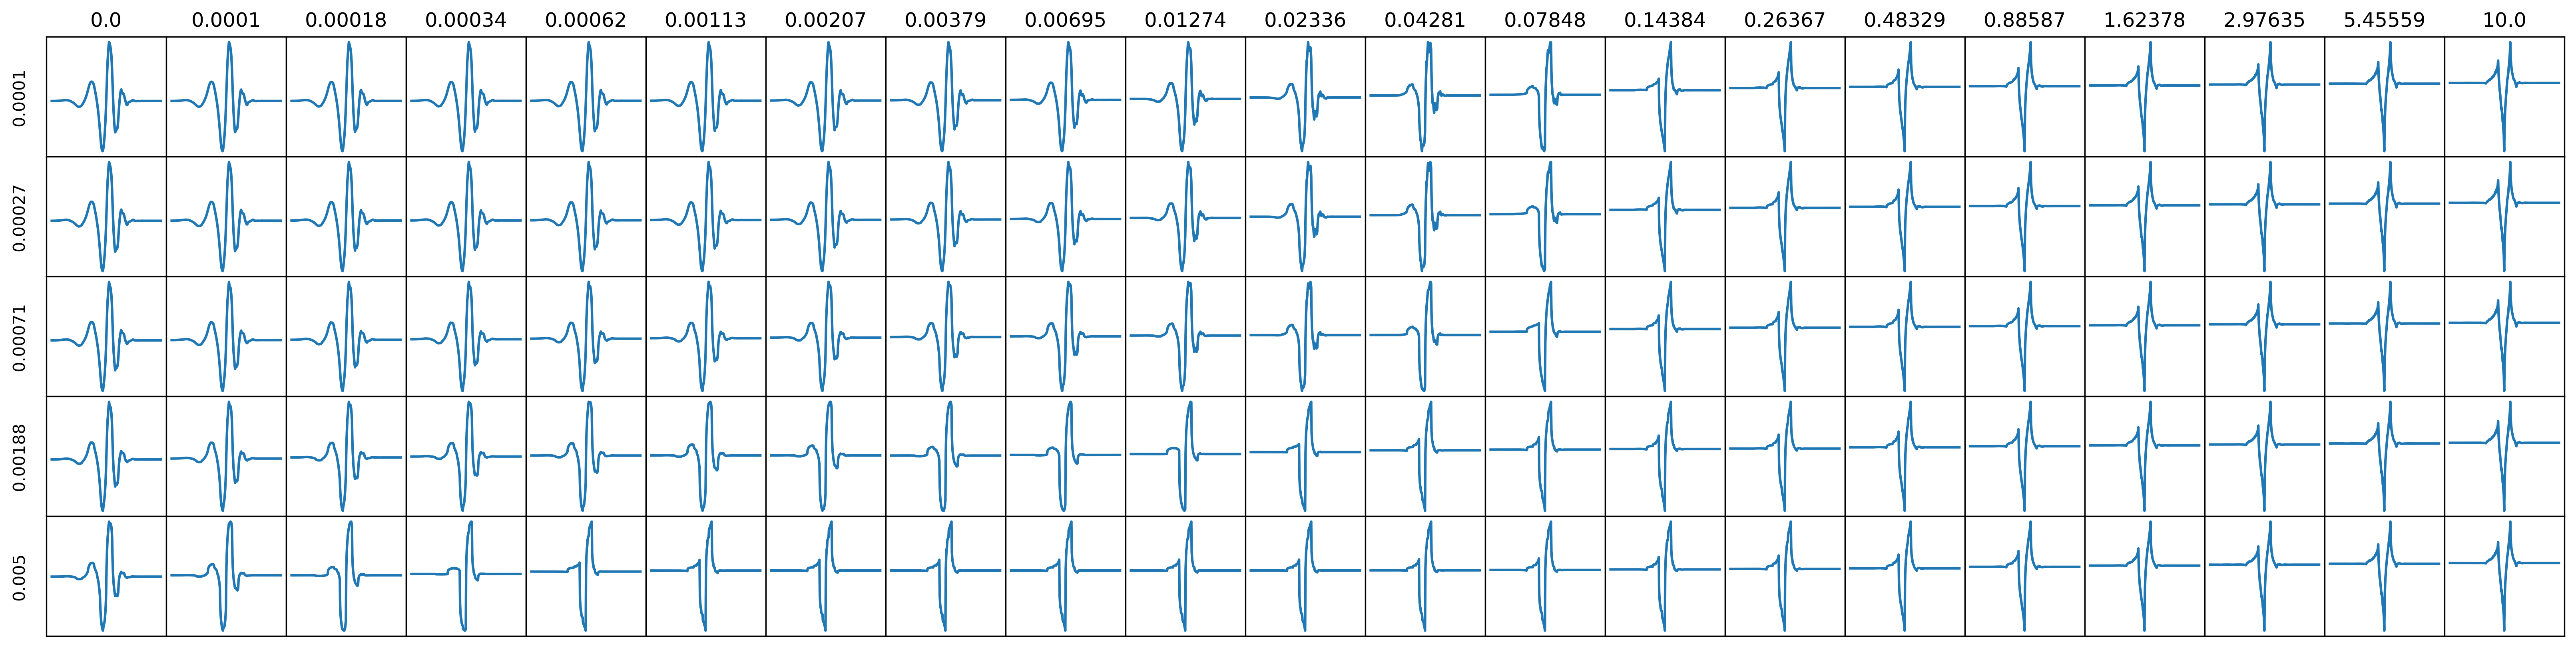

In [26]:
plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

index = 1 # select which result to display
lamwaves = np.fromiter(dics[index]['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dics[index]['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, dics[index]['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))
plt.show() 
